In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as  plt
import numpy as np
%matplotlib inline

In [5]:
words = open('names.txt', 'r').read().splitlines()

chars = sorted(list(set(''.join(words))))
i2s = {p+1:l for p, l in enumerate(chars)}
i2s[0] = '.'

s2i = {}

for i, l in i2s.items():
    s2i[l] = i


In [7]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = s2i[ch] 
            Y.append(ix)
            X.append(context)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(.8*len(words))
n2 = int(.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # train_words
Xdev, Ydev = build_dataset(words[n1:n2]) # dev_words
Xte, Yte = build_dataset(words[n2:]) # test_words



In [24]:
neurons = 200
dimensions = 10 # dimensionality of embedding vector 
vocab_size = 27 # amount of characters (or words)

g2 = torch.Generator().manual_seed(214748364)

C = torch.randn((vocab_size, dimensions), generator=g2) # 27 x n_embeddings this is a 2d vector of all the next possible characters

W1 = torch.randn((block_size * dimensions, neurons), generator=g2) *.01 # weights (block_size(3) x n_embeddings (10))  x N_neurons
b1 = torch.randn(neurons, generator=g2)

W2 = torch.randn((neurons,vocab_size), generator=g2) * .01 # creating second hidden layer which will take in the 100 transformed matrix and connect it to 27 output neurons
b2 = torch.randn(vocab_size , generator = g2) * 0 # bias 


params = [C, W1, W2, b1, b2]
num_params = sum(p.nelement() for p in params)
print(num_params)

11897


tensor(2.2973, grad_fn=<NllLossBackward0>)


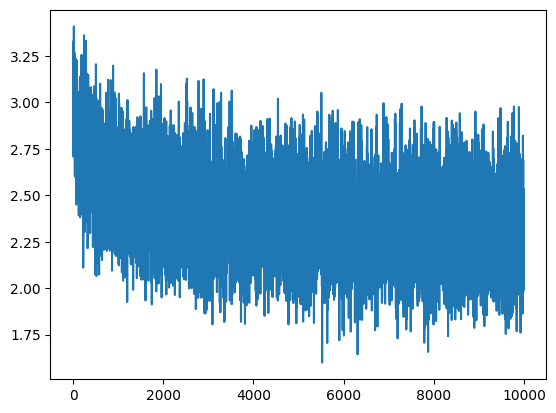

In [25]:
iters = 10000
lri = []
lossi = []

for p in params:
    p.requires_grad = True

for i in range(iters):
    # Mini Sample
    ix = torch.randint(0, Xtr.shape[0], (32,)) # this is a sample from 0 to size of X

    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2 # logits which are outputs
    loss = F.cross_entropy(logits, Ytr[ix])
    # counts = logits.exp()  OLD WAY TO CALCULATE LOSS ==> F.cross_entropy is better
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean() # this plucks the spot of probabilities following each Y
    # print(loss)
    # prob[0].sum()  == 1 #(normalized)

    # backward pass
    for p in params:
        p.grad = None

    # BACK PROPOGATE
    loss.backward()
    
    
    lr = .1 # using minimum found on the graph
    for p in params:
        p.data += -lr * p.grad
        
    # track stats
    lossi.append(loss.item())
    final = loss

x_plot = torch.arange(iters)
plt.plot(x_plot, lossi)
print(final)

In [22]:
# sample from the model
g = torch.Generator().manual_seed(214748364 + 1)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    count = 0
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        count +=1 
        if ix == 0:
            break
        if count == 10:
            break
    
    print(''.join(i2s[i] for i in out))

mali.
aushie.
kei.
acian.
nver.
favanjalee
sathayb.
rashmarish
mathora.
jul.
jaylah.
eleigh.
alossy.
azmim.
even.
yikseraysw
aloe.
akher.
saye.
syressefra


In [28]:
plt.figure(figsiz20,10)
plt.imshow(h.abs() > .99, cmap='gray', interpolation='nearest')

TypeError: Value after * must be an iterable, not int

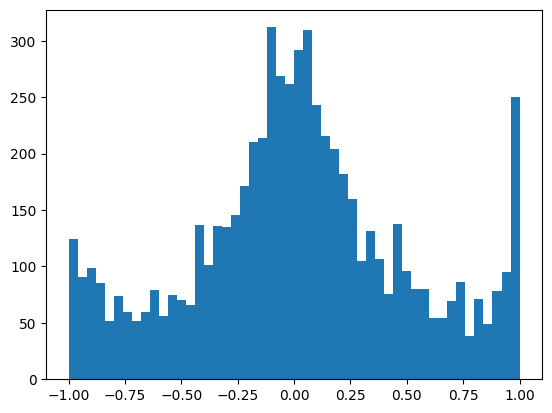

In [26]:
plt.hist(h.view(-1).tolist(), 50);